# **Tutorial for Optimizing NDCG Loss**

**Author**: Zi-Hao Qiu  
**Edited by**: Zhuoning Yuan


**Introduction**

In this tutorial, you will learn how to train a ranking model (e.g., [NeuMF](https://arxiv.org/abs/1708.05031)) by optimizing NDCG using our proposed SONG and K-SONG [[Ref]](https://arxiv.org/abs/2202.12183) on a widely-used movie recommendation dataset [MovieLens 20M](https://grouplens.org/datasets/movielens/20m/). Note that this tutorial requires about 40GB RAM.

**Useful Resources**

* Website: https://libauc.org
* Github: https://github.com/Optimization-AI/LibAUC


**References**

If you find this tutorial helpful in your work,  please acknowledge our library and cite the following papers:
<pre>
@inproceedings{zhu2022auc,
  title={Large-scale Stochastic Optimization of NDCG Surrogates for Deep Learning with Provable Convergence},
  author={Qiu, Zi-Hao and Hu, Quanqi and Zhong, Yongjian and Zhang, Lijun and Yang, Tianbao},
  booktitle={International Conference on Machine Learning},
  pages={18122--18152},
  year={2022},
  publisher={PMLR},
}
</pre>


# **Installing LibAUC**
Let's start with install our library here. In this tutorial, we will use version `1.2.0`.

In [ ]:
!pip install libauc==1.2.0

# **Importing LibAUC**

Import required packages to use

In [2]:
import os
import sys
import time
import random
import numpy as np
import torch
from torch.utils.data import DataLoader

import libauc
from libauc.datasets import MoiveLens
from libauc.sampler.ranking import DataSampler
from libauc.losses.ranking import NDCG_Loss, ListwiseCE_Loss
from libauc.optimizers import SONG
from libauc.models import NeuMF
from libauc.utils.helper import batch_to_gpu, adjust_lr, format_metric, get_time

# **Configurations**

**Reproducibility**  
The following functions limit the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [3]:
def set_all_seeds(SEED):
  import random
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

**Training & Evaluation Settings**

In [4]:
DATA_PATH = 'ml-20m'                 # path for the dataset file
BATCH_SIZE = 256                     # training batch size
EVAL_BATCH_SIZE = 512                # evaluation batch size
EPOCH = 120                          # total training epochs
NUM_WORKERS = 8                      # number of workers in the dataloader
LR_SCHEDULE = '[80]'                 # the lr will multiple 0.25 at 80 epochs
TOPKS = eval('[5,10,20,50]')         # k values for model evaluation (seperated by comma)
METRICS = eval('["NDCG", "MAP"]')    # the list of evaluation metrics (seperated by comma)
MAIN_METRIC = "NDCG@5"               # main metric when evaluation

# **Prepare The Data**

In [5]:
trainSet = MoiveLens(root=DATA_PATH, phase='train')
valSet = MoiveLens(root=DATA_PATH, phase='dev')
testSet = MoiveLens(root=DATA_PATH, phase='test')

Prepare to download dataset...
# Users: 138493
# Items: 26744
# Interactions: 20000263
Time Span: 1995-01-09/2015-03-31
# Users: 138493
# Items: 26744
# Interactions: 18615333
(138493, 4)
Files already downloaded and verified
# Users: 138493
# Items: 26744
# Interactions: 18615333
Files already downloaded and verified
# Users: 138493
# Items: 26744
# Interactions: 18615333


# **Training Function**

In [6]:
import os
import sys
import time
import shutil
from tqdm import tqdm, trange
import numpy as np

# training function
def train(model, train_set, train_sampler, eval_set, optimizer):
    main_metric_results, dev_results = list(), list()
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    try:
        for epoch in range(EPOCH):
            time_s = time.time()

            adjust_lr(LR, LR_SCHEDULE, optimizer, epoch + 1)
            model.train()
            loss_lst = list()

            train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler,
                                      num_workers=NUM_WORKERS, collate_fn=train_set.collate_batch, pin_memory=True)

            for batch in tqdm(train_loader, leave=False, desc='Epoch {:<3}'.format(epoch + 1), ncols=100, mininterval=1):
                batch = batch_to_gpu(batch, DEVICE)
                optimizer.zero_grad()
                out_dict = model(batch)
                loss = criterion(out_dict['prediction'], batch)
                loss.backward()
                optimizer.step()
                loss_lst.append(loss.detach().cpu().data.numpy())

            loss = np.mean(loss_lst).item()

            training_time = time.time() - time_s

            # Record dev results
            dev_result = evaluate(model, eval_set, TOPKS[:1], METRICS)
            dev_results.append(dev_result)
            main_metric_results.append(dev_result[MAIN_METRIC])
            logging_str = 'Epoch {:<5} loss={:<.4f} [{:<3.1f} s]    dev=({})'.format(
                epoch + 1, loss, training_time, format_metric(dev_result))

            # Save model and early stop
            if max(main_metric_results) == main_metric_results[-1]:
                model.save_model(os.path.join(RES_PATH, 'pretrained_model.pkl'))
                logging_str += ' *'
            #logging.info(logging_str)
            print(logging_str)

    except KeyboardInterrupt:
        #logging.info("Early stop manually")
        print ("Early stop manually")
        exit_here = input("Exit completely without evaluation? (y/n) (default n):")
        if exit_here.lower().startswith('y'):
            #logging.info(os.linesep + '-' * 45 + ' END: ' + get_time() + ' ' + '-' * 45)
            print(os.linesep + '-' * 45 + ' END: ' + get_time() + ' ' + '-' * 45)
            exit(1)



# **Evaluation Function**

In [7]:
def evaluate_method(predictions, ratings, topk, metrics):
    """
    :param predictions: (-1, n_candidates) shape, the first column is the score for ground-truth item
    :param ratings: (# of users, # of pos items)
    :param topk: top-K value list
    :param metrics: metric string list
    :return: a result dict, the keys are metric@topk
    """
    evaluations = dict()
    num_of_users, num_pos_items = ratings.shape
    sorted_ratings = -np.sort(-ratings)            # descending order !!
    discounters = np.tile([np.log2(i+1) for i in range(1, 1+num_pos_items)], (num_of_users, 1))
    normalizer_mat = (np.exp2(sorted_ratings) - 1) / discounters

    sort_idx = (-predictions).argsort(axis=1)    # index of sorted predictions (max->min)
    gt_rank = np.array([np.argwhere(sort_idx == i)[:, 1]+1 for i in range(num_pos_items)]).T  # rank of the ground-truth (start from 1)
    for k in topk:
        hit = (gt_rank <= k)
        for metric in metrics:
            key = '{}@{}'.format(metric, k)
            if metric == 'NDCG':
                evaluations[key] = libauc.metrics.ndcg_at_k(ratings, normalizer_mat, hit, gt_rank, k)
            elif metric == 'MAP':
                evaluations[key] = libauc.metrics.map_at_k(hit, gt_rank)
            else:
                raise ValueError('Undefined evaluation metric: {}.'.format(metric))
    return evaluations


def evaluate(model, data_set, topks, metrics):
    """
    The returned prediction is a 2D-array, each row corresponds to all the candidates,
    and the ground-truth item poses the first.
    Example: ground-truth items: [1, 2], 2 negative items for each instance: [[3,4], [5,6]]
             predictions like: [[1,3,4], [2,5,6]]
    """
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    predictions = list()
    ratings = list()
    for idx in trange(0, len(data_set), EVAL_BATCH_SIZE):
        batch = data_set.get_batch(idx, EVAL_BATCH_SIZE)
        prediction = model(batch_to_gpu(batch, DEVICE))['prediction']
        predictions.extend(prediction.cpu().data.numpy())
        ratings.extend(batch['rating'].cpu().data.numpy())

    predictions = np.array(predictions)                                 # [# of users, # of items]
    ratings = np.array(ratings)[:, :NUM_POS]                            # [# of users, # of pos items]

    return evaluate_method(predictions, ratings, topks, metrics)

# **Initial Warm-up**

The target of initial warm-up is to optimize the [listwise cross-entropy loss](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-2007-40.pdf), which is the cross-entropy between predicted and ground-truth top-one probability distributions. We formulate the objective into a finite-sum coupled compositional problem and present the details in Appendix B in our [paper](https://arxiv.org/abs/2202.12183).

We implement the computation of the loss in ```Listwise_CE_Loss``` class, and design an optimizer to handle the update of model parameters implemented by `SONG()`. The key updates are as follows:  
1. $\textbf{u}^{(t+1)}_{q,i}=(1-\gamma_0)\textbf{u}^{(t)}_{q,i}+\gamma_0\frac{1}{|\mathcal{B}_q|}\sum_{x^{'}\in\mathcal{B}_q}\exp(h_q(\textbf{x}^{'};\textbf{w})-h_q(\textbf{x};\textbf{w}))$
2. $G(\textbf{w}_t)=\frac{1}{|\mathcal{Q}_t|}\frac{1}{|\mathcal{B}_{q}^{+}|}\frac{1}{|\mathcal{B}_q|}\sum_{q\in\mathcal{Q}_t}\sum_{\textbf{x}_i^q\in\mathcal{B}_{q}^{+}}\sum_{\textbf{x}_j^q\in\mathcal{B}_{q}}\frac{1}{\textbf{u}^{(t+1)}_{q,i}}\nabla_\textbf{w}(h_q(\textbf{x}_j^q;\textbf{w}_t)-h_q(\textbf{x}_i^q;\textbf{w}_t))$
3. $\textbf{m}_{t+1}=\beta_1\textbf{m}_{t}+(1-\beta_1) G(\textbf{w}_t)$
4. $\textbf{w}_{t+1}=\textbf{w}_{t}-\eta\textbf{m}_{t+1}$

For more details about the algorithm, please refer to our paper. Our implementation requires the following parameters:

**Parameters**
* ```lr```: initial learning rate, the performance is **sensitive** to this parameter.
* ```gamma0```: parameter for moving average in step (1), which is **sensitive**. The default value is 0.1 and you can tune this parameter is the range of (0.0, 1.0).
* ```beta1```: momentum parameter for model update, beta1 is always set to 0.9 similar to that in Adam.

**Define hyper-parameters for the algorithm**

In [8]:
LOSS = 'Listwise_CE'
LR = 0.001                # learning rate of model parameters, \eta in the paper
NUM_POS = 10              # number of positive items sampled for each user
NUM_NEG = 300             # number of negative items sampled for each user
L2 = 1e-7                 # weight_decay
OPTIMIZER_STYLE = 'adam'  # 'sgd' or 'adam'

# GAMMA0 is the moving average factor in our algo, you can tune BETA0 in (0.0, 1.0) for better performance
GAMMA0 = 0.1

n_users = 138493
n_items = 26744
id_mapper, num_relevant_pairs = trainSet.get_id_mapper()

# save the model and log file
RES_PATH = 'warm_up'
os.mkdir(RES_PATH)

**Build training sampler**

In [9]:
train_sampler = DataSampler(labels=trainSet.targets, batch_size=BATCH_SIZE*(NUM_POS+NUM_NEG), num_pos=NUM_POS, num_tasks=BATCH_SIZE)

100%|██████████| 138493/138493 [01:32<00:00, 1494.38it/s]


**Build the model**

In [10]:
set_all_seeds(2022)
model = NeuMF(n_users, n_items)
model.apply(model.init_weights)
model.cuda()

NeuMF(
  (mf_u_embeddings): Embedding(138493, 64)
  (mf_i_embeddings): Embedding(26744, 64)
  (mlp_u_embeddings): Embedding(138493, 64)
  (mlp_i_embeddings): Embedding(26744, 64)
  (mlp): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (prediction): Linear(in_features=128, out_features=1, bias=False)
)

**Build the optimizer and criterion**

In [11]:
criterion = ListwiseCE_Loss(id_mapper=id_mapper, total_relevant_pairs=num_relevant_pairs, num_pos=NUM_POS, gamma0=GAMMA0)
optimizer = SONG(params=model.parameters(), lr=LR, weight_decay=L2, mode=OPTIMIZER_STYLE)

**Launch training**

In [ ]:
EPOCH = 20  
train(model, trainSet, train_sampler, valSet, optimizer)

**Evaluate the model**

In [ ]:
result_dict = evaluate(model, testSet, TOPKS, METRICS)
print("test results:" + format_metric(result_dict))

100%|██████████| 271/271 [08:36<00:00,  1.91s/it]


test results:MAP@5:0.3423,NDCG@5:0.2006,MAP@10:0.3375,NDCG@10:0.2637,MAP@20:0.3156,NDCG@20:0.3215,MAP@50:0.2807,NDCG@50:0.3869


# **SONG**

**S**tochastic **O**ptimization of **N**DC**G** (SONG) is an algorithm for NDCG optimization with provable convergence, which casts the problem into the following equivalent minimization form:  
$$\min_{\textbf{w}\in\mathbb{R}^{d}} F(\textbf{w}):=\frac{1}{|\mathcal{S}|}\sum_{(q,\textbf{x}_i^q)\in|\mathcal{S}|} f_{q,i}(g(\textbf{w},\textbf{x}_i^q,\mathcal{S}_q)),$$ where $g(\textbf{w},\textbf{x}_i^q,\mathcal{S}_q)=\frac{1}{N_q}\bar{g}(\textbf{w},\textbf{x}_i^q,\mathcal{S}_q)$ and $f_{q,i}(g)=\frac{1}{Z_q}\frac{1-2^{y_i^q}}{\log_2(N_q g+1)}$. Please refer to our [paper](https://arxiv.org/abs/2202.12183) for more details.

We implement the computation of the objective in ```NDCG_Loss``` class, and design an optimizer named ```SONG``` to handle the update of model parameters. The key updates are as follows:  
1. $\textbf{u}^{(t+1)}_{q,i}=(1-\gamma_0)\textbf{u}^{(t)}_{q,i}+\gamma_0\frac{1}{|\mathcal{B}_q|}\sum_{x^{'}\in\mathcal{B}_q}\ell(\textbf{w}_t,\textbf{x}^{'},\textbf{x}_i^q,q)$
2. $\textbf{m}_{t+1}=\beta_1\textbf{m}_{t}+(1-\beta_1)G(\textbf{w}_t)$, where $G(\textbf{w}_t)$ is the stochastic gradient estimator
3. $\textbf{w}_{t+1}=\textbf{w}_{t}-\eta_1\textbf{m}_{t+1}$

**Parameters**
* ```lr```: initial learning rate, the performance is **sensitive** to this parameter.
* ```gamma0```: parameter for moving average in step (1), which is **sensitive**. The default value is 0.1 and you can tune this parameter is the range of (0.0, 1.0).
* ```beta1```: momentum parameter for model update, beta1 is always set to 0.9 similar to that in Adam.

**Define hyper-parameters for the algorithm**

In [ ]:
LOSS = 'SONG'
LR = 0.001                # learning rate of model parameters, \eta in the paper
NUM_POS = 10              # number of positive items sampled per user
NUM_NEG = 300             # number of negative items sampled per user
L2 = 1e-7                 # weight_decay
OPTIMIZER_STYLE = 'adam'  # 'sgd' or 'adam'

# GAMMA0 is the moving average factor in our algo, you can tune BETA0 in (0.0, 1.0) for better performance
GAMMA0 = 0.1

n_users = 138493
n_items = 26744
TOPK = -1
id_mapper, num_relevant_pairs = trainSet.get_id_mapper()

# save the model and log file
RES_PATH = 'song'
os.mkdir(RES_PATH)

**Build training sampler**

In [ ]:
train_sampler = DataSampler(labels=trainSet.targets, batch_size=BATCH_SIZE*(NUM_POS+NUM_NEG), num_pos=NUM_POS, num_tasks=BATCH_SIZE)

**Build the model**

In [ ]:
model = NeuMF(n_users, n_items)
model.apply(model.init_weights)
model.cuda()

NeuMF(
  (mf_u_embeddings): Embedding(138493, 64)
  (mf_i_embeddings): Embedding(26744, 64)
  (mlp_u_embeddings): Embedding(138493, 64)
  (mlp_i_embeddings): Embedding(26744, 64)
  (mlp): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (prediction): Linear(in_features=128, out_features=1, bias=False)
)

**Build the optimizer and criterion**

In [ ]:
# 'SONG', 'K-SONG':
model.load_model('./warm_up/pretrained_model.pkl')
model.reset_last_layer()
SONG_GAMMA0 = 0.1
criterion = NDCG_Loss(id_mapper, num_relevant_pairs, n_users, n_items, NUM_POS, gamma0=SONG_GAMMA0, topk=TOPK, topk_version='theo')
optimizer = SONG(params=model.parameters(), lr=LR, weight_decay=L2, mode=OPTIMIZER_STYLE)

**Launch training**

We first adopt the initial warm-up algorithm and train the model for 20 epochs. Then we use SONG and train the model for the last 100 epochs.

In [ ]:
EPOCH = 100  
train(model, trainSet, train_sampler, valSet, optimizer)

**Evaluate the model**

In [ ]:
result_dict = evaluate(model, testSet, TOPKS, METRICS)
print("test results:" + format_metric(result_dict))

100%|██████████| 271/271 [09:03<00:00,  2.01s/it]


test results:MAP@5:0.3642,NDCG@5:0.2212,MAP@10:0.3537,NDCG@10:0.2839,MAP@20:0.3276,NDCG@20:0.3421,MAP@50:0.2896,NDCG@50:0.4049


# **K-SONG**

K-SONG is an algorithm for top-K NDCG optimization with guarantee, which casts the problem into the following bi-level minimization form:  
$$\min_{\textbf{w}\in\mathbb{R}^{d}} \frac{1}{|\mathcal{S}|}\sum_{(q,\textbf{x}_i^q)\in|\mathcal{S}|}\psi(h_q(\textbf{x}_i^q;\textbf{w})-\hat{\lambda}_q (\textbf{w})) f_{q,i}(g(\textbf{w},\textbf{x}_i^q,\mathcal{S}_q))$$ 
$$s.t., \hat{\lambda}_q (\textbf{w})=\arg\min_{\lambda} L_q(\lambda,\textbf{w}), \forall q\in \mathcal{Q},$$
where we employ $f_{q,i}(g)$ to denote $\frac{1}{Z_q^K}\frac{1-2^{y_i^q}}{\log_2(N_q g+1)}$. Please refer to our [paper](https://arxiv.org/abs/2202.12183) for more details.

We implement the computation of the objective in ```NDCG_Loss``` class, and design an optimizer named ```SONG``` to handle the update of model parameters. The key updates are as follows:  
1. $\textbf{u}^{(t+1)}_{q,i}=(1-\gamma_0)\textbf{u}^{(t)}_{q,i}+\gamma_0\frac{1}{|\mathcal{B}_q|}\sum_{x^{'}\in\mathcal{B}_q}\ell(\textbf{w}_t,\textbf{x}^{'},\textbf{x}_i^q,q)$
2. $\textbf{s}_{q,t+1}=(1-\gamma_1)\textbf{s}_{q,t}+\gamma_1\nabla^2_{\lambda\lambda} L_q(\lambda_{q,t};\textbf{w}_w;\mathcal{B}_q)$
3. $\textbf{v}_{q,t+1}=(1-\gamma_1)\textbf{v}_{q,t}+\gamma_1\nabla_{\lambda} L_q(\lambda_{q,t};\textbf{w}_w;\mathcal{B}_q)$
4. $\lambda_{q,t+1}=\lambda_{q,t}-\eta_0\textbf{v}_{q,t+1}$
5. $\textbf{m}_{t+1}=\beta_1\textbf{m}_{t}+(1-\beta_1) G(\textbf{w}_t)$, where $G(\textbf{w}_t)$ is a stochastic gradient estimator
6. $\textbf{w}_{t+1}=\textbf{w}_{t}-\eta_1\textbf{m}_{t+1}$

**Parameters**
* ```lr```: initial learning rate, the performance is **sensitive** to this parameter.
* ```gamma0```: parameter for moving average in step (1), which is **sensitive**. The default value is 0.1 and you can tune this parameter is the range of (0.0, 1.0).
* ```gamma1,beta1```: momentum parameters for model update, they are always set to 0.9 similar to that in Adam.
* ```k```: value specified for top-K NDCG optimization, it should be a interger >= 1.
* ```topk_version```: 'theo' for theoretical K-SONG or 'prac' for practical K-SONG; practical K-SONG does not maintain $s_q$ in step (2)
* ```psi_func```: the function is set to 'sigmoid'

**Define hyper-parameters for the algorithm**

In [ ]:
LOSS = 'K-SONG'
LR = 0.001                # learning rate of model parameters, \eta in the paper
NUM_POS = 10              # number of positive items sampled for each user
NUM_NEG = 300             # number of negative items sampled for each user
L2 = 1e-7                 # weight_decay
OPTIMIZER_STYLE = 'adam'  # 'sgd' or 'adam'

# GAMMA0 is the moving average factor in our algo, you can tune BETA0 in (0.0, 1.0) for better performance
GAMMA0 = 0.1
TOPK = 300
TOPK_V = 'theo' # 'prac' or 'theo'

# save the model and log file
RES_PATH = 'k_song'
os.mkdir(RES_PATH)

**Build training sampler**

In [ ]:
train_sampler = DataSampler(labels=trainSet.targets, batch_size=BATCH_SIZE*(NUM_POS+NUM_NEG), num_pos=NUM_POS, num_tasks=BATCH_SIZE)

100%|██████████| 138493/138493 [01:42<00:00, 1354.23it/s]


**Build the model**

In [ ]:
set_all_seeds(2022)
model = NeuMF(n_users, n_items)
model.apply(model.init_weights)
model.cuda()

NeuMF(
  (mf_u_embeddings): Embedding(138493, 64)
  (mf_i_embeddings): Embedding(26744, 64)
  (mlp_u_embeddings): Embedding(138493, 64)
  (mlp_i_embeddings): Embedding(26744, 64)
  (mlp): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (prediction): Linear(in_features=128, out_features=1, bias=False)
)

**Build the optimizer and criterion**

In [ ]:
model.load_model('./warm_up/pretrained_model.pkl')
model.reset_last_layer()
criterion = NDCG_Loss(id_mapper, num_relevant_pairs, n_users, n_items, NUM_POS, gamma0=GAMMA0, topk=TOPK, topk_version=TOPK_V)
optimizer = SONG(params=model.parameters(), lr=LR, weight_decay=L2, mode=OPTIMIZER_STYLE)

**Launch training**

We first adopt the initial warm-up algorithm and train the model for 20 epochs. Then we use K-SONG and train the model for the last 100 epochs.

In [ ]:
EPOCH = 100  
train(model, trainSet, train_sampler, valSet, optimizer)

**Evaluate the model**

In [ ]:
result_dict = evaluate(model, testSet, TOPKS, METRICS)
print("test results:" + format_metric(result_dict))

# **Visualization**

In [ ]:
# NDCG@5 on dev set for SONG and K-SONG
song_ndcg_at_5 = [0.2128, 0.2216, 0.2642, 0.2864, 0.3003, 0.3087, 0.3163, 0.3218, 0.3273, 0.3326, 0.3365, 0.3389, 0.3418, 0.345, 0.3472, 0.349, 0.3505, 0.3525, 0.354, 0.3549, 0.3343, 0.3405, 0.346, 0.3516, 0.3555, 0.3565, 0.3601, 0.3632, 0.3646, 0.3637, 0.3679, 0.368, 0.369, 0.3697, 0.3721, 0.3724, 0.3724, 0.3733, 0.3739, 0.3741, 0.3733, 0.3754, 0.3762, 0.3761, 0.3781, 0.3782, 0.3782, 0.3792, 0.38, 0.3783, 0.3782, 0.3791, 0.3797, 0.3824, 0.3807, 0.3803, 0.3813, 0.3802, 0.38, 0.3813, 0.383, 0.3811, 0.3821, 0.3823, 0.3829, 0.3819, 0.3813, 0.3844, 0.3838, 0.3821, 0.3829, 0.3809, 0.3806, 0.3832, 0.3822, 0.3839, 0.3853, 0.385, 0.3804, 0.3857, 0.3869, 0.3885, 0.3893, 0.3881, 0.3901, 0.3914, 0.3915, 0.3929, 0.3935, 0.3923, 0.393, 0.3936, 0.3934, 0.3941, 0.3936, 0.3944, 0.3941, 0.3948, 0.3943, 0.3949, 0.3952, 0.3951, 0.3964, 0.3954, 0.3959, 0.3965, 0.3957, 0.3961, 0.3966, 0.3963, 0.3967, 0.3968, 0.3978, 0.3974, 0.3976, 0.3974, 0.3974, 0.3979, 0.3985, 0.3969]
k_song_ndcg_at_5 = [0.2128, 0.2216, 0.2642, 0.2864, 0.3003, 0.3087, 0.3163, 0.3218, 0.3273, 0.3326, 0.3365, 0.3389, 0.3418, 0.345, 0.3472, 0.349, 0.3505, 0.3525, 0.354, 0.3549, 0.3286, 0.3372, 0.3435, 0.3487, 0.3534, 0.3555, 0.3594, 0.3622, 0.3639, 0.365, 0.3676, 0.369, 0.3703, 0.3716, 0.3732, 0.3737, 0.3747, 0.3756, 0.3765, 0.377, 0.3773, 0.379, 0.3785, 0.3802, 0.3818, 0.3817, 0.3824, 0.3838, 0.384, 0.3826, 0.3833, 0.3834, 0.3842, 0.386, 0.3857, 0.3855, 0.3856, 0.3857, 0.3854, 0.3863, 0.3869, 0.3861, 0.3871, 0.3874, 0.3888, 0.3868, 0.3879, 0.3891, 0.3888, 0.3885, 0.3887, 0.3882, 0.3876, 0.3896, 0.3882, 0.3897, 0.3899, 0.39, 0.3882, 0.3918, 0.3926, 0.3937, 0.3947, 0.3936, 0.3954, 0.3953, 0.3961, 0.3974, 0.3973, 0.397, 0.3975, 0.3979, 0.3979, 0.3985, 0.3983, 0.3985, 0.3987, 0.3989, 0.3988, 0.3992, 0.3998, 0.3994, 0.3998, 0.3997, 0.3997, 0.4, 0.3996, 0.4, 0.4004, 0.4005, 0.4006, 0.4004, 0.4008, 0.4009, 0.4009, 0.4009, 0.401, 0.4014, 0.4015, 0.401]

We also include the results of our initial warm-up algorithm and SONG without warm-up

In [ ]:
warmup_ndcg_at_5 = [0.2125, 0.2236, 0.2632, 0.287, 0.3016, 0.3098, 0.3178, 0.3223, 0.3274, 0.3319, 0.336, 0.3386, 0.3418, 0.3441, 0.3463, 0.3479, 0.3498, 0.351, 0.3518, 0.3539, 0.3552, 0.357, 0.3567, 0.3582, 0.3593, 0.3601, 0.3607, 0.3605, 0.3612, 0.3614, 0.3613, 0.3632, 0.3629, 0.3634, 0.3646, 0.3653, 0.3652, 0.3648, 0.3655, 0.3668, 0.3649, 0.3673, 0.3664, 0.3665, 0.3672, 0.368, 0.3679, 0.3686, 0.368, 0.3685, 0.3688, 0.3686, 0.3684, 0.3686, 0.3696, 0.3684, 0.3702, 0.3691, 0.3684, 0.3697, 0.3684, 0.3699, 0.3697, 0.3691, 0.3686, 0.3702, 0.3681, 0.3691, 0.369, 0.3707, 0.3683, 0.3702, 0.3688, 0.3697, 0.3696, 0.3696, 0.3701, 0.3686, 0.3686, 0.3691, 0.37, 0.3698, 0.3698, 0.3709, 0.3709, 0.3716, 0.3718, 0.3714, 0.3724, 0.3729, 0.3727, 0.3726, 0.3723, 0.3727, 0.3726, 0.3722, 0.3725, 0.3713, 0.3719, 0.3718, 0.3723, 0.3716, 0.3714, 0.3719, 0.3715, 0.3717, 0.372, 0.3711, 0.3708, 0.3714, 0.3711, 0.3711, 0.3709, 0.3706, 0.37, 0.371, 0.3703, 0.3707, 0.37, 0.3708]
song_wo_warmup = [0.221, 0.2212, 0.2211, 0.2265, 0.2409, 0.2604, 0.2735, 0.2844, 0.2923, 0.3002, 0.3062, 0.3107, 0.3173, 0.3203, 0.3246, 0.3275, 0.3314, 0.334, 0.3363, 0.3398, 0.3424, 0.3426, 0.3438, 0.347, 0.3486, 0.3491, 0.3511, 0.3525, 0.3545, 0.3532, 0.3567, 0.3573, 0.3578, 0.3596, 0.3603, 0.3598, 0.3616, 0.3624, 0.3621, 0.3646, 0.365, 0.3649, 0.3656, 0.3673, 0.3668, 0.3694, 0.3697, 0.37, 0.3712, 0.3711, 0.371, 0.3724, 0.3728, 0.3737, 0.3743, 0.375, 0.374, 0.3759, 0.3763, 0.3777, 0.3781, 0.3781, 0.3796, 0.3794, 0.3805, 0.3798, 0.3805, 0.3815, 0.3818, 0.3823, 0.3829, 0.3834, 0.3829, 0.3832, 0.3837, 0.3837, 0.3844, 0.3845, 0.3847, 0.3854, 0.3855, 0.3856, 0.3861, 0.3858, 0.386, 0.3865, 0.387, 0.3871, 0.387, 0.3867, 0.387, 0.3874, 0.3875, 0.3881, 0.3875, 0.388, 0.3882, 0.388, 0.3883, 0.3888, 0.3887, 0.3885, 0.3891, 0.3891, 0.389, 0.3892, 0.3893, 0.3896, 0.3898, 0.3899, 0.39, 0.39, 0.3906, 0.3905, 0.3908, 0.3907, 0.391, 0.3906, 0.3911, 0.3908]

**Compare with tensorflow-ranking lib**  
We compare our optimization framework with [Tensorflow Ranking](https://www.tensorflow.org/ranking), which is an open-source library for neural learning to rank (LTR). We compare our SONG and K-SONG with four list-wise ranking approaches in Tensorflow-Ranking, including [ListNet](https://www.tensorflow.org/ranking/api_docs/python/tfr/keras/losses/SoftmaxLoss), [ListMLE](https://www.tensorflow.org/ranking/api_docs/python/tfr/keras/losses/ListMLELoss), [ApproxNDCG](https://www.tensorflow.org/ranking/api_docs/python/tfr/keras/losses/ApproxNDCGLoss), and [GumbelApproxNDCG](https://www.tensorflow.org/ranking/api_docs/python/tfr/keras/losses/GumbelApproxNDCGLoss).  
Results indicate that our methods are better than these four methods in terms of NDCG values.

The results of methods from Tensorflow Ranking can be obtained via running ```run_tf.py```

In [ ]:
# NDCG@5 of ListNet, ListMLE, ApproxNDCG, and GumbelApproxNDGC
tf_listnet = [0.2171, 0.2493, 0.2841, 0.3067, 0.3196, 0.329, 0.3317, 0.3376, 0.3349, 0.3381, 0.3404, 0.3438, 0.3461, 0.3444, 0.3464, 0.3499, 0.3507, 0.3518, 0.3523, 0.3537, 0.3542, 0.3541, 0.3538, 0.3557, 0.3563, 0.3577, 0.3589, 0.3592, 0.3595, 0.357, 0.3605, 0.3607, 0.3579, 0.3592, 0.361, 0.36, 0.3597, 0.3615, 0.3621, 0.3619, 0.3601, 0.3613, 0.3623, 0.3619, 0.362, 0.3618, 0.3602, 0.3621, 0.3629, 0.361, 0.3647, 0.3626, 0.3638, 0.365, 0.3629, 0.3666, 0.3645, 0.3672, 0.3663, 0.3646, 0.3662, 0.3673, 0.3685, 0.368, 0.3688, 0.3687, 0.368, 0.3676, 0.3679, 0.3691, 0.3677, 0.3683, 0.3676, 0.367, 0.3677, 0.3683, 0.3675, 0.3674, 0.3683, 0.3678, 0.3685, 0.3684, 0.3669, 0.3678, 0.3679, 0.3685, 0.367, 0.3676, 0.3671, 0.3677, 0.3658, 0.3662, 0.3657, 0.3669, 0.3662, 0.3666, 0.3669, 0.3668, 0.3668, 0.3669, 0.3645, 0.3649, 0.3676, 0.3665, 0.366, 0.3654, 0.3657, 0.3672, 0.3655, 0.3659, 0.366, 0.366, 0.367, 0.3656, 0.3663, 0.366, 0.3669, 0.3662, 0.3667, 0.3657]
tf_listmle = [0.2122, 0.2125, 0.2145, 0.2335, 0.251, 0.2622, 0.2678, 0.2719, 0.2767, 0.2807, 0.2846, 0.2892, 0.2924, 0.2953, 0.2978, 0.2997, 0.3021, 0.3069, 0.3082, 0.3096, 0.3116, 0.3144, 0.3159, 0.3182, 0.3195, 0.3207, 0.3222, 0.3238, 0.3241, 0.3253, 0.3281, 0.3294, 0.3312, 0.3316, 0.3322, 0.3322, 0.3346, 0.3361, 0.336, 0.3368, 0.3373, 0.3374, 0.337, 0.3394, 0.3403, 0.3408, 0.3409, 0.3421, 0.3427, 0.3421, 0.3437, 0.3439, 0.3426, 0.344, 0.3438, 0.3447, 0.3443, 0.3451, 0.3455, 0.3457, 0.3463, 0.3468, 0.3468, 0.3465, 0.3474, 0.3468, 0.3473, 0.3475, 0.3476, 0.3482, 0.3471, 0.3481, 0.3482, 0.3473, 0.3481, 0.3481, 0.3495, 0.3495, 0.3496, 0.3495, 0.349, 0.3491, 0.3496, 0.3495, 0.3506, 0.35, 0.3499, 0.3503, 0.3503, 0.3509, 0.3508, 0.3507, 0.3509, 0.3508, 0.3511, 0.351, 0.3504, 0.3508, 0.3512, 0.3507, 0.351, 0.3501, 0.3504, 0.3507, 0.3505, 0.3506, 0.3507, 0.3511, 0.351, 0.3513, 0.3513, 0.3504, 0.351, 0.3517, 0.3508, 0.3511, 0.3507, 0.351, 0.3516, 0.3508]
tf_approxndcg = [0.2205, 0.2191, 0.2169, 0.2179, 0.2174, 0.2189, 0.217, 0.2179, 0.2176, 0.2188, 0.2178, 0.2181, 0.2184, 0.2183, 0.2189, 0.2201, 0.2214, 0.2233, 0.2255, 0.2314, 0.3042, 0.3136, 0.3183, 0.321, 0.3241, 0.3269, 0.3289, 0.3302, 0.3313, 0.3323, 0.3328, 0.3337, 0.3346, 0.3351, 0.3368, 0.3366, 0.3375, 0.337, 0.3368, 0.3366, 0.3399, 0.3384, 0.3382, 0.3401, 0.3387, 0.3412, 0.3419, 0.342, 0.3423, 0.342, 0.3409, 0.3419, 0.3436, 0.3436, 0.3439, 0.3434, 0.3453, 0.3439, 0.3433, 0.3442, 0.3453, 0.3469, 0.3477, 0.3473, 0.3483, 0.3492, 0.3488, 0.3487, 0.3499, 0.3512, 0.3509, 0.3511, 0.3519, 0.3514, 0.3519, 0.3534, 0.3541, 0.3526, 0.3532, 0.3533, 0.3536, 0.3544, 0.3542, 0.3551, 0.3554, 0.3557, 0.3567, 0.3559, 0.3554, 0.3557, 0.3561, 0.3572, 0.3567, 0.3554, 0.3574, 0.3575, 0.3572, 0.357, 0.3565, 0.357, 0.3575, 0.3579, 0.3574, 0.3572, 0.3567, 0.3569, 0.3578, 0.3572, 0.3574, 0.3564, 0.3572, 0.3581, 0.3572, 0.3587, 0.3583, 0.3574, 0.3583, 0.359, 0.3592, 0.3586]
tf_gumbelapproxndcg = [0.2201, 0.2186, 0.2196, 0.2193, 0.2195, 0.2209, 0.2323, 0.2675, 0.2891, 0.3014, 0.3101, 0.3172, 0.3227, 0.3264, 0.3307, 0.3338, 0.3354, 0.3378, 0.3384, 0.3403, 0.3415, 0.3422, 0.3428, 0.344, 0.3452, 0.3467, 0.3467, 0.345, 0.3461, 0.3477, 0.3461, 0.3461, 0.3471, 0.3491, 0.3464, 0.3495, 0.3469, 0.3485, 0.348, 0.3473, 0.3478, 0.3472, 0.3484, 0.3498, 0.3479, 0.3526, 0.3505, 0.3526, 0.3499, 0.35, 0.3496, 0.3507, 0.3491, 0.3511, 0.3503, 0.3495, 0.3513, 0.3516, 0.3513, 0.3492, 0.3525, 0.3538, 0.3535, 0.3547, 0.3549, 0.3554, 0.3561, 0.3553, 0.3561, 0.3566, 0.3565, 0.357, 0.3582, 0.357, 0.3584, 0.3582, 0.3588, 0.3588, 0.36, 0.3594, 0.3595, 0.36, 0.359, 0.3598, 0.3613, 0.36, 0.3607, 0.36, 0.3591, 0.3601, 0.3599, 0.3601, 0.3598, 0.3602, 0.3603, 0.3611, 0.3608, 0.36, 0.3595, 0.3594, 0.3601, 0.3602, 0.3598, 0.3602, 0.3589, 0.3593, 0.3592, 0.3598, 0.3607, 0.3593, 0.3597, 0.3597, 0.3596, 0.3596, 0.3593, 0.3593, 0.359, 0.3604, 0.3599, 0.359]

**Comparison of convergence of different methods in terms of validation NDCG@5**

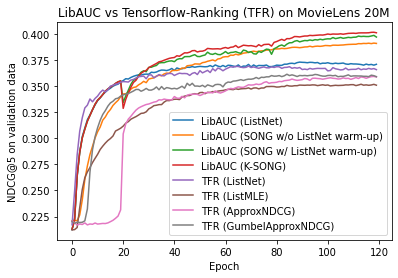

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(warmup_ndcg_at_5, label='LibAUC (ListNet)')
plt.plot(song_wo_warmup, label='LibAUC (SONG w/o ListNet warm-up)')
plt.plot(song_ndcg_at_5, label='LibAUC (SONG w/ ListNet warm-up)')
plt.plot(k_song_ndcg_at_5, label='LibAUC (K-SONG)')
plt.plot(tf_listnet, label='TFR (ListNet)')
plt.plot(tf_listmle, label='TFR (ListMLE)')
plt.plot(tf_approxndcg, label='TFR (ApproxNDCG)')
plt.plot(tf_gumbelapproxndcg, label='TFR (GumbelApproxNDCG)')
plt.title('LibAUC vs Tensorflow-Ranking (TFR) on MovieLens 20M')
plt.xlabel('Epoch')
plt.ylabel('NDCG@5 on validation data')
plt.legend()
plt.show()

**We also compare the training time per epoch of each method on one Tesla M40 GPU. The training time for SONG/K-SONG is the weighted average of 20 epochs warm-up and 100 epochs SONG/K-SONG optimization.** 

In [ ]:
method_list = ['TFR\n(ListNet)','TFR\n(ListMLE)','TFR\n(Approx-\nNDCG)','TFR\n(Gumbel-\nApproxNDCG)','LibAUC\n(SONG)','LibAUC\n(K-SONG)']
time_list = [44, 45, 48, 73, 43, 46]
color_list = ['blue','blue','blue','blue','orange','orange']

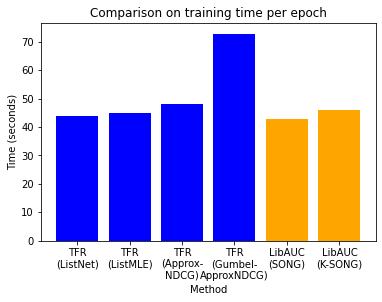

In [ ]:
plt.bar(method_list, time_list, color=color_list)
plt.title('Comparison on training time per epoch')
plt.xlabel('Method')
plt.ylabel('Time (seconds)')
plt.show()